In [1]:
import ll

ll.pretty()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [2]:
from pathlib import Path

id = "asz41quw"
base_path = Path("/workspaces/repositories/jmp-peft/lltrainer")
print(base_path)

path = base_path / id / "predictions"
print(path)

!ls -l {path} | head -n 10

/workspaces/repositories/jmp-peft/lltrainer
/workspaces/repositories/jmp-peft/lltrainer/asz41quw/predictions
  × could not find pixi.toml or pyproject.toml which is configured to use pixi

total 21508
-rw-r--r-- 1 root root  19616 May 28 00:43 prediction_rank0_batch0.pt
-rw-r--r-- 1 root root   5036 May 28 01:00 prediction_rank0_batch1000.pt
-rw-r--r-- 1 root root   5036 May 28 01:00 prediction_rank0_batch1001.pt
-rw-r--r-- 1 root root  10732 May 28 01:00 prediction_rank0_batch1002.pt
-rw-r--r-- 1 root root  18476 May 28 01:00 prediction_rank0_batch1003.pt
-rw-r--r-- 1 root root  20460 May 28 01:00 prediction_rank0_batch1004.pt
-rw-r--r-- 1 root root   9388 May 28 01:00 prediction_rank0_batch1005.pt
-rw-r--r-- 1 root root   8108 May 28 01:00 prediction_rank0_batch1006.pt
-rw-r--r-- 1 root root  13420 May 28 01:00 prediction_rank0_batch1007.pt


In [3]:
pt_files = list(path.glob("*.pt"))
# print(pt_files)
# Sort by batch idx
pt_files.sort(key=lambda x: int(x.stem.rsplit("_", 1)[1][len("batch") :]))

In [4]:
import pandas as pd
from matbench_discovery import Key
from matbench_discovery.data import DATA_FILES

df_summary = pd.read_csv(DATA_FILES.wbm_summary).set_index(Key.mat_id)
df_summary

Loading 'wbm_summary' from cached file at '/root/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


,formula,n_sites,volume,uncorrected_energy,e_form_per_atom_wbm,e_above_hull_wbm,bandgap_pbe,wyckoff_spglib_initial_structure,uncorrected_energy_from_cse,e_correction_per_atom_mp2020,e_correction_per_atom_mp_legacy,e_form_per_atom_uncorrected,e_form_per_atom_mp2020_corrected,e_above_hull_mp2020_corrected_ppd_mp,site_stats_fingerprint_init_final_norm_diff,wyckoff_spglib,unique_prototype
material_id,,,,,,,,,,,,,,,,,
wbm-1-1,Ac6 U2,8.0,317.48,-42.954,0.550,0.550,0.0,A3B_hP8_194_h_c:Ac-U,-42.955387,0.000,0.0,0.544327,0.544327,0.544310,0.128576,A3B_hP8_194_h_c:Ac-U,True
wbm-1-2,Ac1 Th3,4.0,137.42,-25.858,0.125,0.125,0.0,AB3_tI8_139_a_bd:Ac-Th,-25.858142,0.000,0.0,0.126190,0.126190,0.126152,0.051626,AB3_tI8_139_a_bd:Ac-Th,True
wbm-1-3,Ac1 U3,4.0,100.81,-34.934,0.768,0.768,0.0,AB3_tI8_139_a_bd:Ac-U,-34.934045,0.000,0.0,0.765339,0.765339,0.765340,0.061782,AB3_tI8_139_a_bd:Ac-U,True
wbm-1-4,Ag2 Au1 Hg1,4.0,76.26,-9.114,0.030,0.063,0.0,A2BC_cF16_225_c_a_b:Ag-Au-Hg,-9.114021,0.000,0.0,0.032195,0.032195,0.062869,0.067272,A2BC_cF16_225_c_a_b:Ag-Au-Hg,True
wbm-1-5,Ag2 Ba1 La1,4.0,124.15,-13.222,-0.178,0.100,0.0,A2BC_cF16_225_c_a_b:Ag-Ba-La,-13.222006,0.000,0.0,-0.175452,-0.175452,0.092193,0.050158,A2BC_cF16_225_c_a_b:Ag-Ba-La,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wbm-5-23304,I2 Te2 Zr2,6.0,203.35,-31.883,-0.911,0.021,0.0,ABC_oP6_59_a_a_b:I-Te-Zr,-31.885257,-0.267,0.0,-0.926076,-1.193076,0.019279,0.352661,ABC_oP6_59_a_a_b:I-Te-Zr,True
wbm-5-23305,Tl2 Zr2,4.0,92.16,-21.578,0.062,0.141,0.0,AB_cP2_221_a_b:Tl-Zr,-21.579593,0.000,0.0,0.060252,0.060252,0.139899,0.029811,AB_cP2_221_a_b:Tl-Zr,False
wbm-5-23306,Pb2 Tm1 Zr1,4.0,108.43,-21.085,-0.163,0.126,0.0,A2BC_tI8_139_d_a_b:Pb-Tm-Zr,-21.081939,0.000,0.0,-0.158310,-0.158310,0.113990,0.546470,A2BC_tI8_139_d_a_b:Pb-Tm-Zr,True


In [5]:
import gzip
import pickle

from pymatgen.analysis.phase_diagram import PatchedPhaseDiagram

with gzip.open(DATA_FILES.mp_patched_phase_diagram, "rb") as zip_file:
    ppd_mp: PatchedPhaseDiagram = pickle.load(zip_file)

ppd_mp

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b5ab43cc3d0>>
Traceback (most recent call last):
  File "/opt/conda/envs/jmp-peft/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


PatchedPhaseDiagram covering 46216 sub-spaces

In [ ]:
df_cse = pd.read_json(DATA_FILES.wbm_computed_structure_entries)
df_cse = df_cse.set_index(Key.mat_id)
df_cse

,formula_from_cse,computed_structure_entry
material_id,,
wbm-1-1,Ac6 U2,{'@module': 'pymatgen.entries.computed_entries...
wbm-1-2,Ac1 Th3,{'@module': 'pymatgen.entries.computed_entries...
wbm-1-3,Ac1 U3,{'@module': 'pymatgen.entries.computed_entries...
wbm-1-4,Ag2 Au1 Hg1,{'@module': 'pymatgen.entries.computed_entries...
wbm-1-5,Ag2 Ba1 La1,{'@module': 'pymatgen.entries.computed_entries...
...,...,...
wbm-5-23304,I2 Te2 Zr2,{'@module': 'pymatgen.entries.computed_entries...
wbm-5-23305,Tl2 Zr2,{'@module': 'pymatgen.entries.computed_entries...
wbm-5-23306,Pb2 Tm1 Zr1,{'@module': 'pymatgen.entries.computed_entries...


In [ ]:
from pymatgen.entries.computed_entries import ComputedStructureEntry

cse = ComputedStructureEntry.from_dict(df_cse.iloc[101].computed_structure_entry)
x = ppd_mp.get_e_above_hull(cse)
# cse.structure
cse.energy_per_atom, x

(-3.48408222375, 0.04619022722826083)

In [ ]:
x = ppd_mp.get_pd_for_entry(cse.structure.composition)
# print(x)

In [ ]:
import torch

file = pt_files[11]

data = torch.load(file, map_location="cpu")
print(data.keys())

id = data["batch"]["id"]
df_summary.loc[id]

dict_keys(['relax_out', 'batch'])


,formula,n_sites,volume,uncorrected_energy,e_form_per_atom_wbm,e_above_hull_wbm,bandgap_pbe,wyckoff_spglib_initial_structure,uncorrected_energy_from_cse,e_correction_per_atom_mp2020,e_correction_per_atom_mp_legacy,e_form_per_atom_uncorrected,e_form_per_atom_mp2020_corrected,e_above_hull_mp2020_corrected_ppd_mp,site_stats_fingerprint_init_final_norm_diff,wyckoff_spglib,unique_prototype
material_id,,,,,,,,,,,,,,,,,
wbm-4-28332,As2 O1 Rb2 Tm2,7.0,193.32,-35.759,-1.607,0.031,0.11,A2BC2D2_tI14_139_e_a_e_c:As-O-Rb-Tm,-35.760909,-0.098143,-0.100327,-1.511916,-1.610058,0.030441,0.865104,A2BC2D2_tI14_139_e_a_e_c:As-O-Rb-Tm,True


In [ ]:
from typing import cast

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.entries.compatibility import (
    MaterialsProject2020Compatibility,
)  # see https://github.com/materialsproject/pymatgen/blob/master/pymatgen/io/vasp/inputs.py#L1738

file = pt_files[10]

data = torch.load(file, map_location="cpu")

device = torch.device("cpu")

model = CHGNet.load().to(device)
# model.is_intensive = False
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()


final_structure = cast(
    Structure, Structure.from_dict(data["relax_out"]["final_structure"])
)
graph = cast(CrystalGraph, converter(final_structure))

# Compute the energy
with torch.no_grad(), torch.inference_mode():
    out = model([graph.to(device)], task="e")
    # print(out)
    energy = out["e"].view(-1).item()

# Hull energy

cse = ComputedStructureEntry.from_dict(df_cse.loc[data["batch"]["id"], Key.cse].item())
cse._structure = final_structure
# e_form_per_atom = get_e_form_per_atom(cse)
# cse._energy = cse.energy_per_atom * cse.composition.num_atoms
cse._energy = energy
# print(cse.composition)
print("1", cse._energy)

# processed = MaterialsProject2020Compatibility().process_entries(
#     cse, verbose=True, clean=True
# )
# assert isinstance(processed, list) and len(processed) == 1
# cse = processed[0]
# print("2", cse._energy)

# e_above_hull = ppd_mp.get_e_above_hull(cse)
e_form_per_atom = get_e_form_per_atom(cse)
print("3", e_form_per_atom)

# # cse = ComputedStructureEntry.from_dict(cse_dict)
# # print(cse)

# print(processed)

# e_form_per_atom = get_e_form_per_atom(
#     dict(energy=processed.energy, composition=processed.composition)
# )
# e_form_per_atom

# energy = data["relax_out"]["trajectory"]["energy"][-1]

# e_form = get_e_form_per_atom(
#     {
#         "energy": energy,
#         # "energy": data["relax_out"]["trajectory"]["energy"][-1],
#         "composition": final_structure.composition,
#     }
# )

print(
    cse.composition.num_atoms,
    (energy, e_form_per_atom, energy / cse.composition.num_atoms),
    (
        data["batch"]["y"].item(),
        data["batch"]["y_formation"].item(),
        data["batch"]["y_above_hull"].item(),
    ),
)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1
1 -4.859119415283203
3 2.3622600730895997
8.0 (-4.859119415283203, 2.3622600730895997, -0.6073899269104004) (-0.017698679119348526, -1.8781440258026123, -0.010060999542474747)


In [ ]:
from typing import cast

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry

file = pt_files[50]

data = torch.load(file, map_location="cpu")

device = torch.device("cpu")

model = CHGNet.load().to(device)
model.is_intensive = False
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()

final_structure = cast(
    Structure, Structure.from_dict(data["relax_out"]["final_structure"])
)
graph = cast(CrystalGraph, converter(final_structure))

# Compute the energy
with torch.no_grad(), torch.inference_mode():
    out = model([graph.to(device)], task="e")
    energy = out["e"].view(-1).item()

cse = ComputedStructureEntry.from_dict(df_cse.loc[data["batch"]["id"], Key.cse].item())
cse._structure = final_structure
cse._energy = energy

e_form_per_atom = get_e_form_per_atom(cse)


print(
    cse.composition.num_atoms,
    (energy, e_form_per_atom, energy / cse.composition.num_atoms),
    (
        # data["batch"]["y"].item(),
        data["batch"]["y_formation"].item(),
        data["batch"]["y_above_hull"].item(),
    ),
)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:0
6.0 (0.30243635177612305, 3.747039391962687, 0.05040605862935384) (-0.16378700733184814, 0.2003829926252365)


In [12]:
import rich


rich.print(data["batch"])

{
    'pos': array[6, 3] f32 n=18 x∈[-0.001, 4.535] μ=1.654 σ=1.636,
    'id': ['wbm-3-5374'],
    'atomic_numbers': array[6] i64 x∈[13, 56] μ=27.667 σ=20.039 [56, 56, 13, 13, 14, 14],
    'cell': array[1, 3, 3] f32 n=9 x∈[-1.978, 5.877] μ=1.490 σ=2.688 [[[3.955, 0., 2.422e-16], [-1.978, 5.559, 
3.613e-16], [0., 0., 5.877]]],
    'y_formation': array[1] f32 [-0.164],
    'y_above_hull': array[1] f32 [0.200],
    'natoms': array[1] i64 [6],
    'y': array[1] f32 [-0.018],
    'force': array[6, 3] f32 n=18 all_zeros,
    'tags': array[6] i64 x∈[2, 2] μ=2.000 σ=0. [2, 2, 2, 2, 2, 2],
    'fixed': array[6] bool all_zeros [False, False, False, False, False, False],
    'force_norm_mean': array[6, 3] f32 n=18 all_zeros,
    'force_norm_std': array[6, 3] f32 n=18 x∈[0.566, 0.566] μ=0.566 σ=0.,
    'y_norm_mean': array[1] f32 [0.559],
    'y_norm_std': array[1] f32 [31.590],
    'batch': array[6] i64 all_zeros [0, 0, 0, 0, 0, 0],
    'ptr': array[2] i64 μ=3.000 σ=3.000 [0, 6]
}

In [13]:
import numpy as np


diff = (
    df_summary["e_above_hull_mp2020_corrected_ppd_mp"]
    # == data["batch"]["y_above_hull"].item()
    # We don't want equality here because the values are floats
).sub(data["batch"]["y_above_hull"].item())
mask = diff.abs() < 1e-6
mask.sum()


def get_row(e_above_hull: torch.Tensor | np.ndarray | float):
    if not isinstance(e_above_hull, float):
        e_above_hull = float(e_above_hull.item())

    diff = (df_summary["e_above_hull_mp2020_corrected_ppd_mp"] - e_above_hull).abs()
    mask = diff.abs() < 1e-6

    # Number of matches should be 1
    assert mask.sum() == 1

    idx = mask.idxmax()
    # Get the row
    row = df_summary.loc[idx]
    return row


get_row(data["batch"]["y_above_hull"])

formula                                                       Al2 Ba2 Si2
n_sites                                                               6.0
volume                                                             154.62
uncorrected_energy                                                -23.305
e_form_per_atom_wbm                                                -0.185
e_above_hull_wbm                                                     0.15
bandgap_pbe                                                           0.0
wyckoff_spglib_initial_structure               ABC_oC12_63_a_c_c:Al-Ba-Si
uncorrected_energy_from_cse                                    -23.304523
e_correction_per_atom_mp2020                                     0.023667
e_correction_per_atom_mp_legacy                                       0.0
e_form_per_atom_uncorrected                                     -0.187454
e_form_per_atom_mp2020_corrected                                -0.163787
e_above_hull_mp2020_corrected_ppd_mp  

In [16]:
from typing import Any


data["batch"]["y_above_hull"]
data["batch"]["y_formation"]


def correct_energy(
    chgnet_pred: torch.Tensor,
    batch: dict[str, Any],
    divide_by_num_atoms: bool = False,
):
    """
    To avoid confusion for anyone reading this code, we calculate the formation energy MAE
    here and report it as the MAE for the energy above the convex hull prediction. The
    former is more easily calculated but the two quantities are the same. The formation
    energy of a material is the difference in energy between a material and its
    constituent elements in their standard states. The distance to the convex hull is
    defined as the difference between a material's formation energy and the minimum
    formation energy of all possible stable materials made from the same elements. Since
    the formation energy of a material is used to calculate the distance to the convex
    hull, the error of a formation energy prediction directly determines the error in the
    distance to the convex hull prediction.

    A further point of clarification: whenever we say convex hull distance we mean
    the signed distance that is positive for thermodynamically unstable materials above
    the hull and negative for stable materials below it.

    See https://github.com/pbenner/matbench-discovery/blob/818173c68f434b02d4139c7fb032bd703af83fe9/matbench_discovery/preds.py#L221-L234
    From Matbench discovery:

    # dataframe of all models' energy above convex hull (EACH) predictions (eV/atom)
    df_each_pred = pd.DataFrame()
    for model in models:
        df_each_pred[model] = (
            df_preds[Key.each_true] + df_preds[model] - df_preds[Key.e_form]
        )
    """

    y_formation_pred = chgnet_pred
    if divide_by_num_atoms:
        y_formation_pred = y_formation_pred / batch["natoms"]

    # each_true => batch["y_above_hull"] => e_above_hull_mp2020_corrected_ppd_mp
    # e_form => batch["y_formation"] => e_form_per_atom_mp2020_corrected

    y_above_hull_true = batch["y_above_hull"].item()
    y_formation_true = batch["y_formation"].item()

    y_above_hull_pred = y_above_hull_true + y_formation_pred - y_formation_true
    return (y_formation_true, y_above_hull_true), (y_above_hull_pred, y_formation_pred)

In [17]:
from typing import cast

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry

print(len(pt_files))
file = pt_files[1]

data = torch.load(file, map_location="cpu")

device = torch.device("cpu")

model = CHGNet.load().to(device)
model.is_intensive = False
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()

final_structure = cast(
    Structure, Structure.from_dict(data["relax_out"]["final_structure"])
)
graph = cast(CrystalGraph, converter(final_structure))

# Compute the energy
with torch.no_grad(), torch.inference_mode():
    out = model([graph.to(device)], task="e")
    energy = out["e"].view(-1).item()

(
    (y_formation_true, y_above_hull_true),
    (y_formation_pred, y_above_hull_pred),
) = correct_energy(energy, data["batch"], divide_by_num_atoms=True)
rich.print(
    {"y_formation_pred": y_formation_pred, "y_above_hull_pred": y_above_hull_pred},
    {"y_formation_true": y_formation_true, "y_above_hull_true": y_above_hull_true},
)

1024
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1


{'y_formation_pred': array[1] [-0.182], 'y_above_hull_pred': array[1] [-0.253]}
{'y_formation_true': -0.021984999999403954, 'y_above_hull_true': 0.048907000571489334}

In [22]:
from typing import cast

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry

print(len(pt_files))
file = pt_files[1]

data = torch.load(file, map_location="cpu")

device = torch.device("cpu")

model = CHGNet.load().to(device)
# model.is_intensive = False
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()

final_structure = cast(
    Structure, Structure.from_dict(data["relax_out"]["final_structure"])
)
graph = cast(CrystalGraph, converter(final_structure))

# Compute the energy
with torch.no_grad(), torch.inference_mode():
    out = model([graph.to(device)], task="e")
    energy = out["e"].view(-1).item()


energy = get_e_form_per_atom(
    {"energy": energy, "composition": final_structure.composition}
)

(
    (y_formation_true, y_above_hull_true),
    (y_formation_pred, y_above_hull_pred),
) = correct_energy(energy, data["batch"], divide_by_num_atoms=False)
rich.print(
    {"y_formation_pred": y_formation_pred, "y_above_hull_pred": y_above_hull_pred},
    {"y_formation_true": y_formation_true, "y_above_hull_true": y_above_hull_true},
)

1024
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1


{'y_formation_pred': 6.42568127485017, 'y_above_hull_pred': 6.354789274279277}
{'y_formation_true': -0.021984999999403954, 'y_above_hull_true': 0.048907000571489334}

In [ ]:
# - MACE energy predictions

In [23]:
import ase
from ase.visualize import view

data = torch.load(pt_files[32], map_location="cpu")
batch = data["batch"]
print(batch)

batch_idx = 0

out_structure = Structure.from_dict(data["relax_out"]["final_structure"])
# mask = batch["batch"] == batch_idx
pos = data["relax_out"]["trajectory"]["atom_positions"][0]
pos = out_structure.cart_coords
atomic_numbers = batch["atomic_numbers"]
cell = batch["cell"][batch_idx]
print(pos.shape, atomic_numbers.shape, cell.shape)

atoms = ase.Atoms(positions=pos, numbers=atomic_numbers, cell=cell, pbc=True)
view(atoms)

{'pos': array[11, 3] f32 n=33 x∈[-4.287, 6.937] μ=1.412 σ=2.386, 'id': ['wbm-3-72883'], 'atomic_numbers': array[11] i64 x∈[50, 79] μ=62.000 σ=13.605, 'cell': array[1, 3, 3] f32 n=9 x∈[-3.509, 6.938] μ=1.065 σ=3.877 [[[6.029, 0., -3.509], [-2.037, 5.674, -3.509], [0., 0., 6.938]]], 'y_formation': array[1] f32 [-0.236], 'y_above_hull': array[1] f32 [0.093], 'natoms': array[1] i64 [11], 'y': array[1] f32 [-0.018], 'force': array[11, 3] f32 n=33 all_zeros, 'tags': array[11] i64 x∈[2, 2] μ=2.000 σ=0., 'fixed': array[11] bool all_zeros, 'force_norm_mean': array[11, 3] f32 n=33 all_zeros, 'force_norm_std': array[11, 3] f32 n=33 x∈[0.566, 0.566] μ=0.566 σ=0., 'y_norm_mean': array[1] f32 [0.559], 'y_norm_std': array[1] f32 [31.590], 'batch': array[11] i64 all_zeros, 'ptr': array[2] i64 μ=5.500 σ=5.500 [0, 11]}
(11, 3) (11,) (3, 3)


<Popen: returncode: None args: ['/opt/conda/envs/jmp-peft/bin/python', '-m',...>

In [24]:
from typing import cast
from tqdm.auto import tqdm

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry


device = torch.device("cpu")

model = CHGNet.load().to(device)
model.is_intensive = False
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()


y_formation_preds: list[float] = []
y_formation_trues: list[float] = []

y_above_hull_preds: list[float] = []
y_above_hull_trues: list[float] = []


for file in tqdm(pt_files):
    data = torch.load(file, map_location=device)

    final_structure = cast(
        Structure, Structure.from_dict(data["relax_out"]["final_structure"])
    )
    graph = cast(CrystalGraph, converter(final_structure))

    # Compute the energy
    with torch.no_grad(), torch.inference_mode():
        out = model([graph.to(device)], task="e")
        energy = out["e"].view(-1).item()

    energy = get_e_form_per_atom(
        {"energy": energy, "composition": final_structure.composition}
    )

    (
        (y_formation_true, y_above_hull_true),
        (y_formation_pred, y_above_hull_pred),
    ) = correct_energy(energy, data["batch"], divide_by_num_atoms=False)

    y_formation_preds.append(float(y_formation_pred))
    y_formation_trues.append(float(y_formation_true))
    y_above_hull_preds.append(float(y_above_hull_pred))
    y_above_hull_trues.append(float(y_above_hull_true))

rich.print({})

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1


  0%|          | 0/1024 [00:00<?, ?it/s]

{}

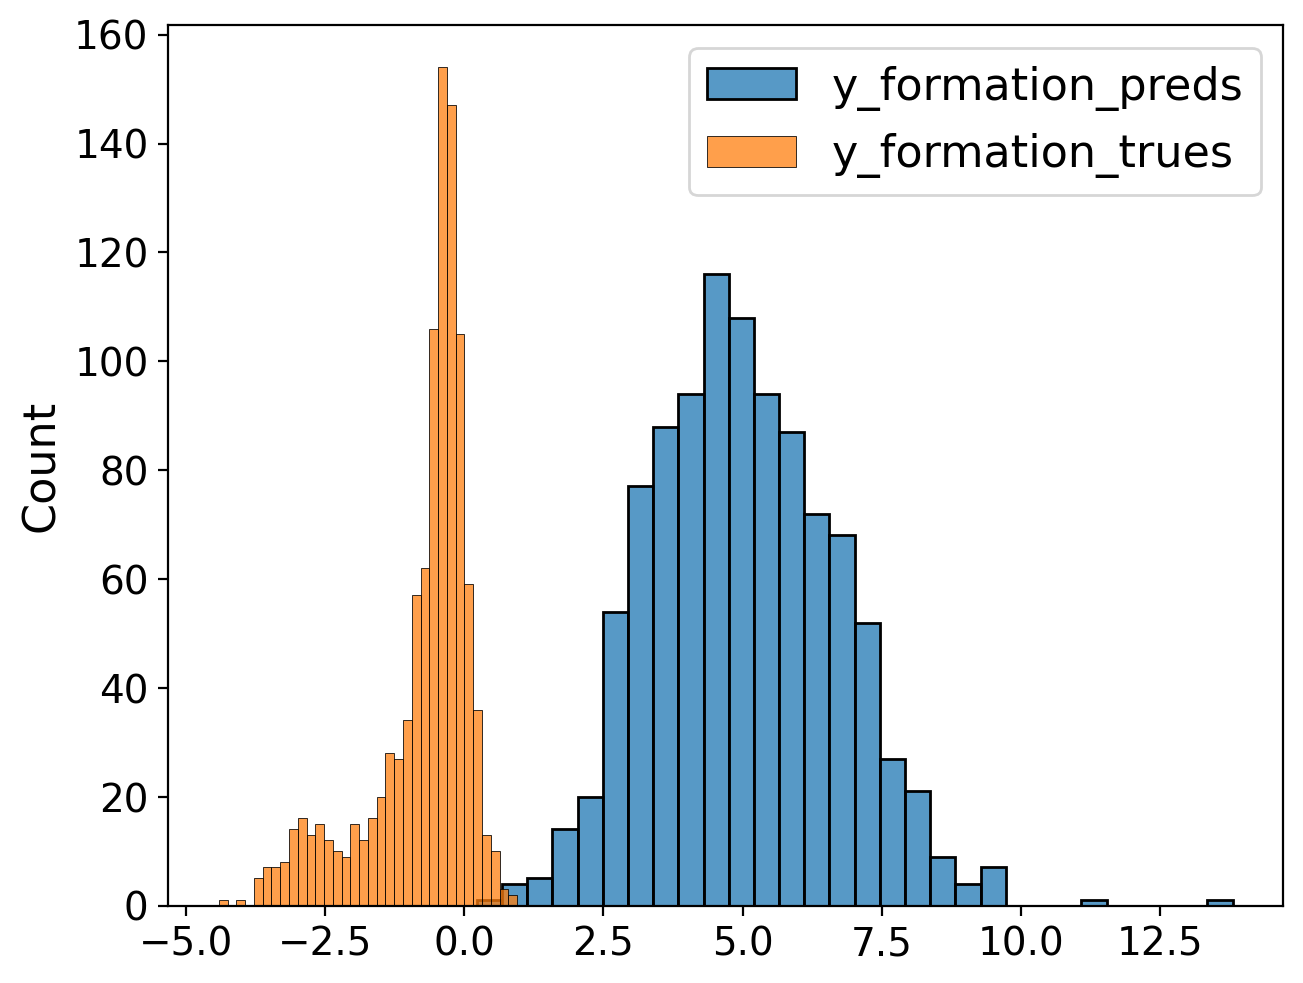

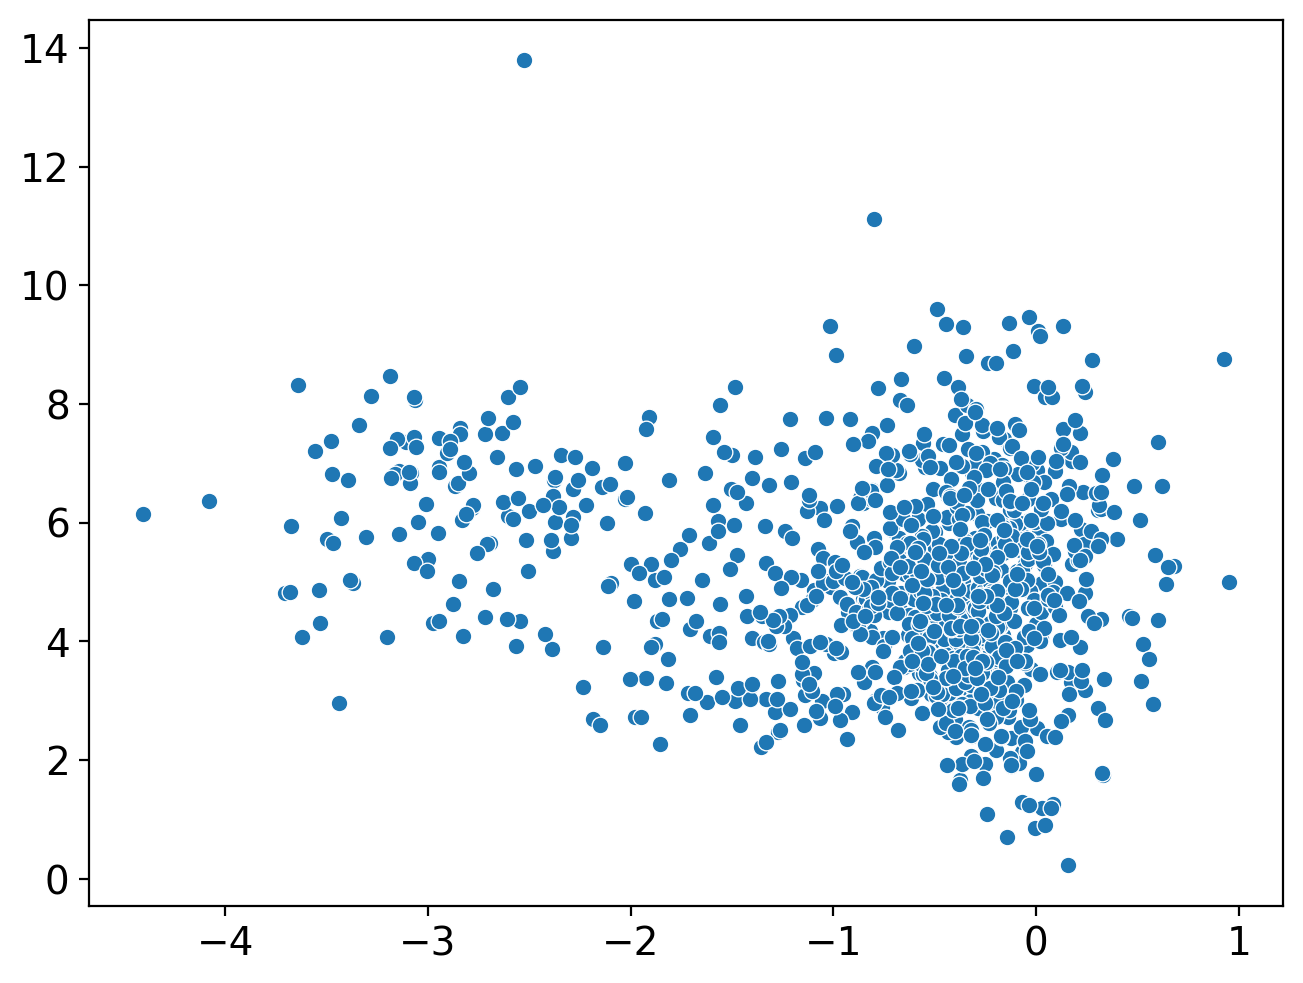

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(np.array(y_formation_preds), label="y_formation_preds")
sns.histplot(np.array(y_formation_trues), label="y_formation_trues")
plt.legend()
plt.show()

sns.scatterplot(x=y_formation_trues, y=y_formation_preds)
plt.show()

# sns.histplot(np.array(y_formation_preds))
# plt.show()

# TODO: Run MACE on force prediction task

/opt/conda/envs/jmp-peft/lib/python3.11/site-packages/matbench_discovery/metrics.py:111: RuntimeWarning: invalid value encountered in scalar divide
  precision = n_true_pos / (n_true_pos + n_false_pos)  # model's discovery rate


{
    'F1': nan,
    'DAF': nan,
    'Precision': nan,
    'Recall': 0.0,
    'Accuracy': 0.833984375,
    'TPR': 0.0,
    'FPR': 0.0,
    'TNR': 1.0,
    'FNR': 1.0,
    'TP': 0,
    'FP': 0,
    'TN': 854,
    'FN': 170,
    'MAE': 4.015199357174473,
    'RMSE': 4.330970616576737,
    'R2': -245.74442449648262
}

{'mae': 5.769310393314832}

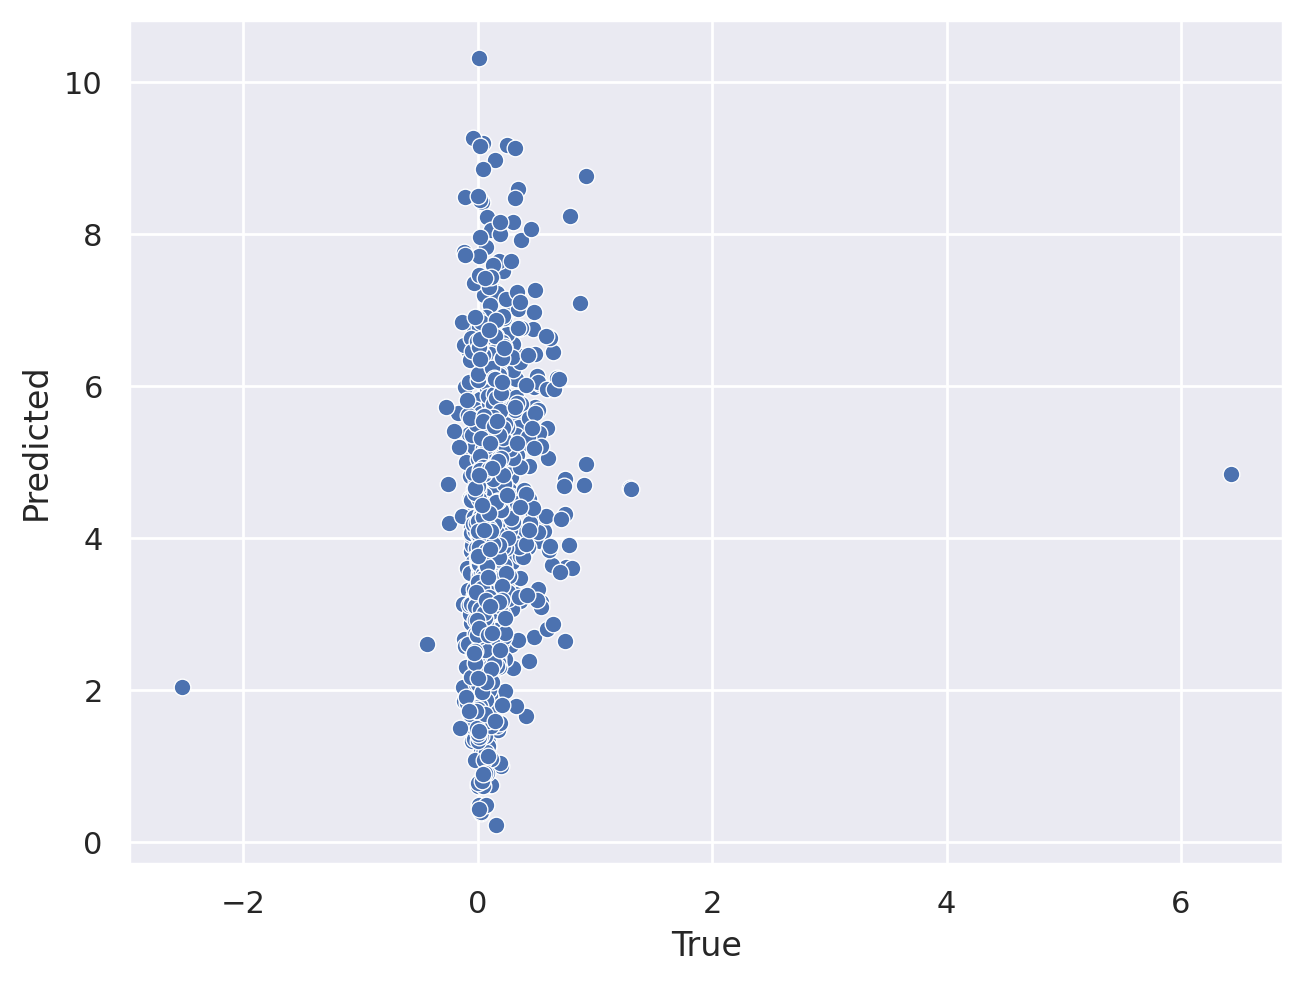

In [26]:
from matbench_discovery.metrics import stable_metrics

metrics = stable_metrics(
    np.array(y_above_hull_trues),
    np.array(y_above_hull_preds),
    fillna=False,
)
rich.print(metrics)

# Also print MAE of formation energy
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_formation_trues, y_formation_preds)
rich.print({"mae": mae})

# Draw a scatter plot of the true vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook")

plt.figure()
sns.scatterplot(x=y_above_hull_trues, y=y_above_hull_preds)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [126]:
from typing import cast
from tqdm.auto import tqdm

from chgnet.graph import CrystalGraph
from chgnet.graph.converter import CrystalGraphConverter
from chgnet.model import CHGNet
from matbench_discovery.energy import get_e_form_per_atom
from pymatgen.core import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry


device = torch.device("cpu")

model = CHGNet.load().to(device)
model.is_intensive = True
model.eval()

converter = CrystalGraphConverter(
    atom_graph_cutoff=12.0,
    bond_graph_cutoff=6.0,
).to(device)
converter.eval()


y_formation_preds: list[float] = []
y_formation_trues: list[float] = []

y_above_hull_preds: list[float] = []
y_above_hull_trues: list[float] = []


for file in tqdm(pt_files):
    data = torch.load(file, map_location=device)

    final_structure = cast(
        Structure, Structure.from_dict(data["relax_out"]["final_structure"])
    )
    graph = cast(CrystalGraph, converter(final_structure))

    # Compute the energy
    with torch.no_grad(), torch.inference_mode():
        out = model([graph.to(device)], task="e")
        energy = out["e"].view(-1).item()

    (
        (y_formation_true, y_above_hull_true),
        (y_formation_pred, y_above_hull_pred),
    ) = correct_energy(energy, data["batch"], divide_by_num_atoms=False)

    y_formation_preds.append(float(y_formation_pred))
    y_formation_trues.append(float(y_formation_true))
    y_above_hull_preds.append(float(y_above_hull_pred))
    y_above_hull_trues.append(float(y_above_hull_true))

rich.print({})

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1


  0%|          | 0/1024 [00:00<?, ?it/s]

{}

In [130]:
model = CHGNet.load().to(device)

model.is_intensive

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda:1


True

: 

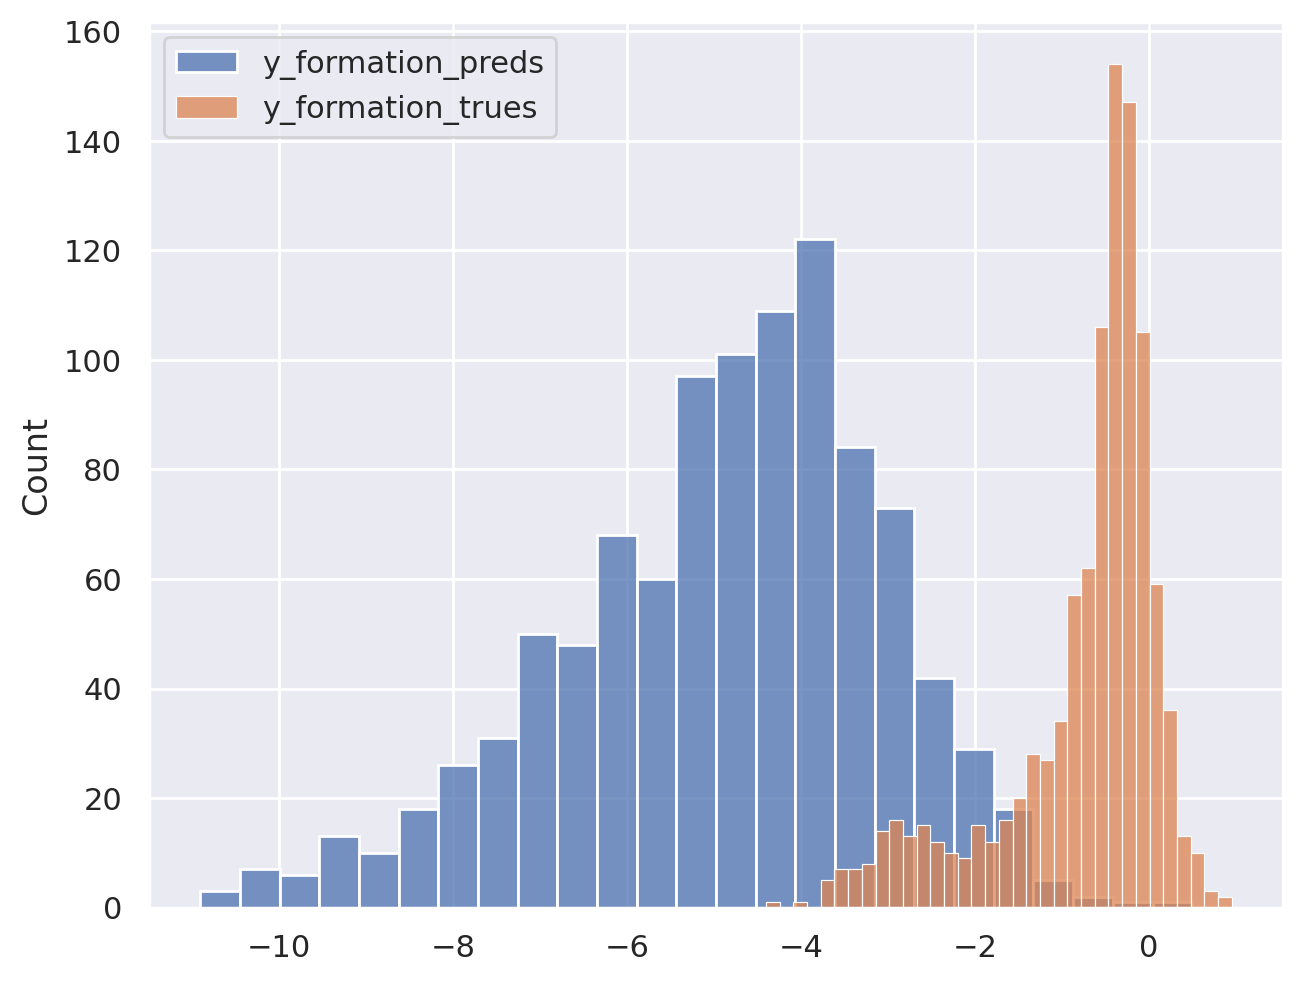

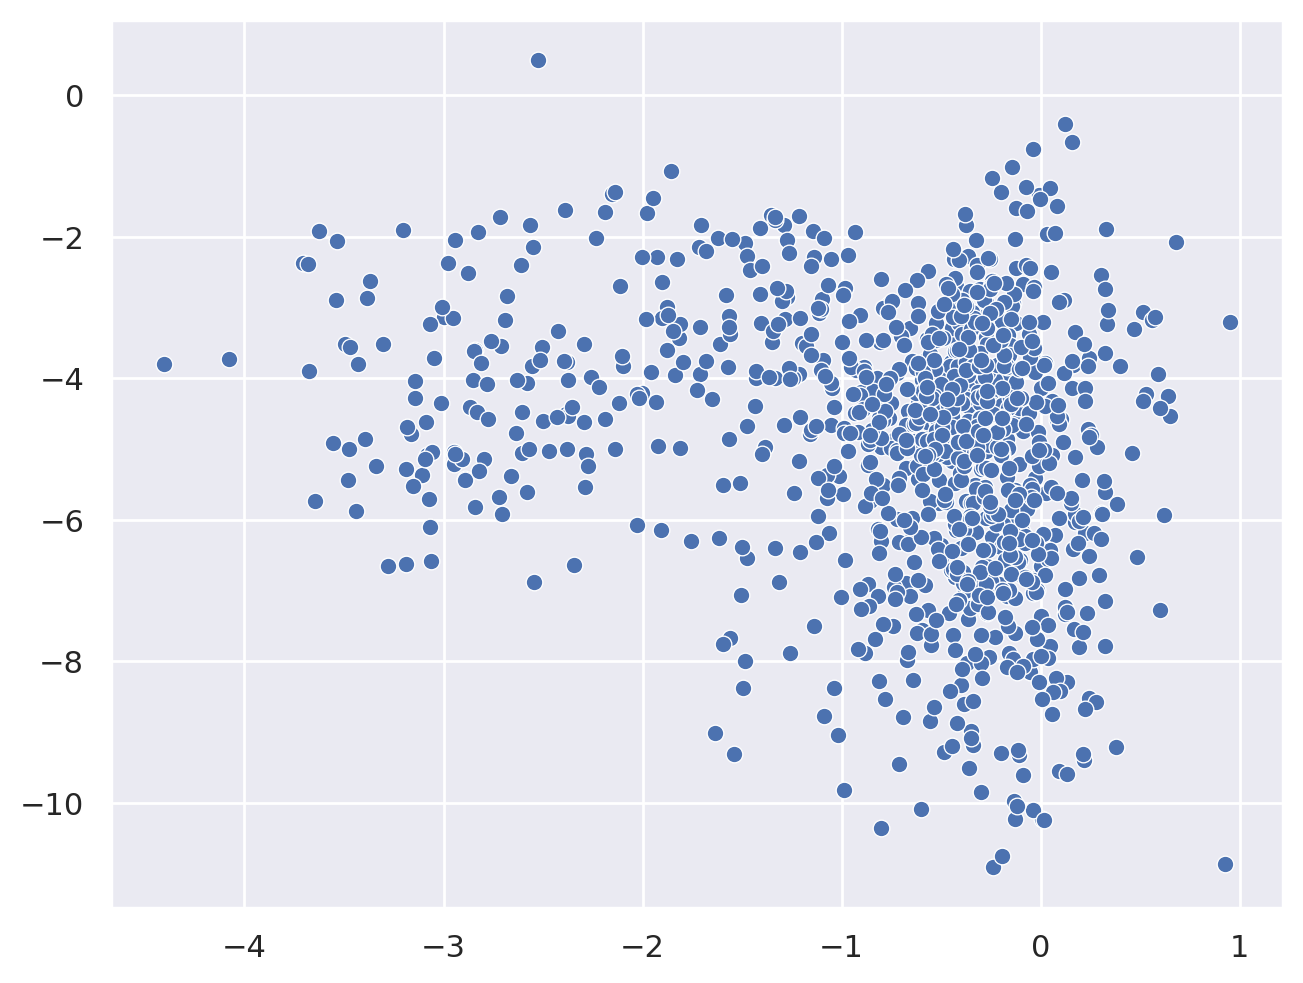

In [128]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(np.array(y_formation_preds), label="y_formation_preds")
sns.histplot(np.array(y_formation_trues), label="y_formation_trues")
plt.legend()
plt.show()

sns.scatterplot(x=y_formation_trues, y=y_formation_preds)
plt.show()

# sns.histplot(np.array(y_formation_preds))
# plt.show()

{
    'F1': 0.2847571189279732,
    'DAF': 1.0,
    'Precision': 0.166015625,
    'Recall': 1.0,
    'Accuracy': 0.166015625,
    'TPR': 1.0,
    'FPR': 1.0,
    'TNR': 0.0,
    'FNR': 0.0,
    'TP': 170,
    'FP': 854,
    'TN': 0,
    'FN': 0,
    'MAE': 5.884446806037754,
    'RMSE': 6.186340838561909,
    'R2': -502.4363399001134
}

{'mae': 4.17172865043587}

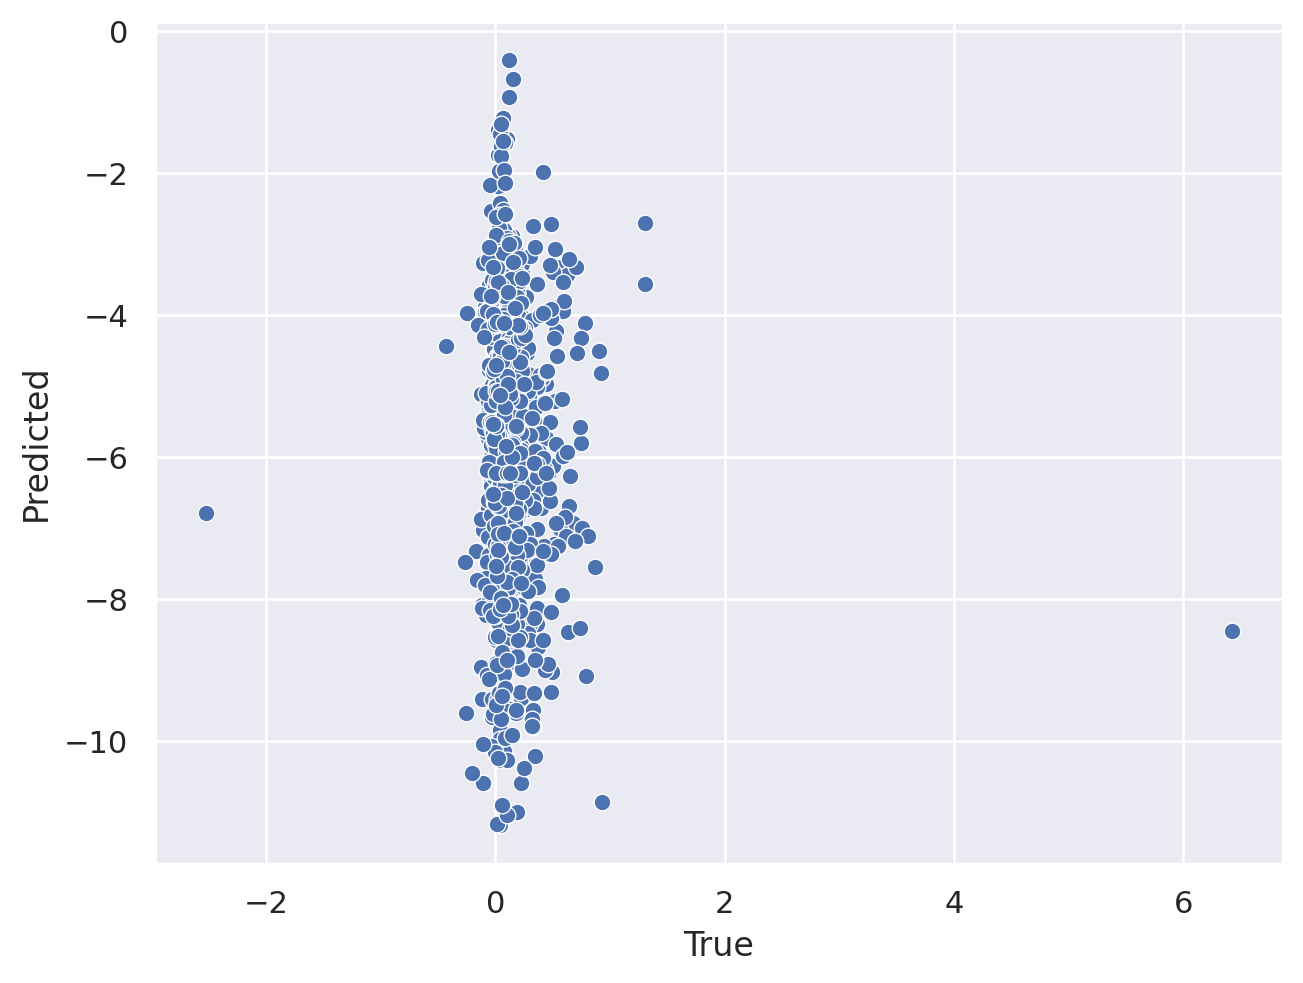

In [127]:
from matbench_discovery.metrics import stable_metrics

metrics = stable_metrics(
    np.array(y_above_hull_trues),
    np.array(y_above_hull_preds),
    fillna=False,
)
rich.print(metrics)

# Also print MAE of formation energy
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_formation_trues, y_formation_preds)
rich.print({"mae": mae})

# Draw a scatter plot of the true vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook")

plt.figure()
sns.scatterplot(x=y_above_hull_trues, y=y_above_hull_preds)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()